Multi-Labelled Odors Classification using Neural Networks and Graphic Neural Networks
=======

made by Jina a.k.a SUMIGAMJA

Part 2. Graphic Neural Networks (GNNs)
-

In [1]:
# Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rdkit
import torch
torch.autograd.set_detect_anomaly(True) # for error description
torch.manual_seed(42) # 42 is THE MAGIC SEED

from torch_geometric.utils import from_smiles
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fs

import random
random.seed(42)

from sklearn import metrics

In [2]:
#dataset 중 SMIELS와 multi-labeled output만 가져오기
df = pd.read_csv('./final_descriptors.csv')
df = df.iloc[:, [0] + list(range(211, df.shape[1]))]
#df.head()

In [3]:
# 데이터셋 로드 (예: CSV 파일)
df = pd.read_csv('./final_descriptors.csv')
df = df.dropna(axis = 0, how = 'any')
SMILES = df.iloc[:, 0]  # 첫 번째 열
OUTPUT = df.iloc[:, 211:].values.tolist()  # 138개의 output 데이터를 리스트로 변환

# 두 번째 열을 배열의 형식으로 저장
df = pd.DataFrame({
    'SMILES': SMILES,
    'OUTPUT': OUTPUT
})

# 결과 출력
#print(df.head())

In [4]:
train, validation, test = np.split(df.sample(frac = 1, random_state = 42),
                                   [int(0.8 * len(df)), int(0.9 * len(df))])
print(f"Train : {len(train)} | Validate : {len(validation)} | Test : {len(test)}")

Train : 3900 | Validate : 487 | Test : 488


/PROGRAMS/miniconda3/envs/Torch/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
train_dataset = [(from_smiles(row['SMILES']), torch.tensor(row['OUTPUT'], dtype = torch.float)) for idx, row in train.iterrows()]
validation_dataset = [(from_smiles(row['SMILES']), torch.tensor(row['OUTPUT'], dtype = torch.float)) for idx, row in validation.iterrows()]
test_dataset = [(from_smiles(row['SMILES']), torch.tensor(row['OUTPUT'], dtype = torch.float)) for idx, row in test.iterrows()]

In [6]:
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = 256, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = True)

In [7]:
import Cycle # Model & Cycle definition in here

In [8]:
def objective_function(input_array):
    
    # print(input_array)
    input_array = input_array.flatten()
    
    parameters = {
        'in_channels' : 9,
        'hidden_channels' : int(input_array[0]),
        'out_channels' : 138, 
        'edge_dim' : int(input_array[1]),
        'num_layers' : int(input_array[2]),
        'num_timesteps' : int(input_array[3]),
        'lr' : input_array[4],
        'pos_weight' : int(input_array[5]),
        'dropout' : 0.2
    }

    cycle = Cycle.GNN(
            parameters = parameters,
            loaders = (train_loader, validation_loader, test_loader)
    )

    result = cycle.run(5)

    print(result)
    
    return np.array([result])
    
bounds = (np.array([16, 2, 2, 2, 1E-2, 2]),
          np.array([512, 16, 64, 32, 1E-4, 128]))

options = {'c1' : 0.5, 'c2' : 0.3, 'w' : 0.9}

optimizer = ps.single.GlobalBestPSO(
    n_particles = 6,
    dimensions = 6,
    bounds = bounds,
    options = options
)

In [9]:
stats = optimizer.optimize(
    objective_function,
    iters = 10,
    n_processes = 6, #: 노드 사용
)

print(stats)

2025-01-25 17:32:19,669 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|                                        |0/10


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
model = AttentiveFP(in_channels = 9,
                    hidden_channels = 128,
                    out_channels = 138,
                    edge_dim = 3,
                    num_layers = 2,
                    num_timesteps = 2,
                    dropout = 0.2) # 이거는 hyper 냅두기

for batch, y in test_loader:
    print(batch)
    batch.x = batch.x.to(torch.float)
    print(model(batch.x, batch.edge_index, batch.edge_attr, batch.batch))
    break

DataBatch(x=[3247, 9], edge_index=[2, 6366], edge_attr=[6366, 3], smiles=[256], batch=[3247], ptr=[257])
tensor([[ 2.3017, -1.8099, -0.9266,  ..., -2.2368,  0.4280, -0.3368],
        [ 5.2954, -5.7766, -4.6089,  ..., -3.6997, -0.3027, -0.6556],
        [ 1.5800, -1.5077, -0.9188,  ..., -0.9665,  0.6032, -0.3817],
        ...,
        [ 1.8888, -3.4488, -2.8119,  ..., -1.9528, -0.5330, -0.5152],
        [ 2.4435, -2.9178, -1.6988,  ..., -1.4779,  1.3540, -0.3641],
        [ 3.1900, -4.3551, -2.6673,  ..., -1.7572,  0.1640, -1.2557]],
       grad_fn=<AddmmBackward0>)


In [11]:
run(50)

Exception: File `'(50)'` not found.

In [13]:
# Model Performance Check

with torch.no_grad():
    model.eval()

    test_loss = 0.0
    pred = []; true = []

    for batch, y in test_loader:
        batch.x = batch.x.to(torch.float)
        
        y = np.array(y)
        y = torch.tensor(y, dtype=torch.float32).reshape(-1, 138)
        
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        test_loss += criterion(out, y)

        out = torch.nn.functional.sigmoid(out)
        
        pred.append(out.numpy())
        true.append(y.numpy())

test_loss = test_loss.item() / len(test_loader)
pred = np.concatenate(pred)
true = np.concatenate(true)

#pred = pred.astype(int)
pred = pred.astype(int)
true = true.astype(int)

/tmp/ipykernel_2472523/3318022937.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y = np.array(y)


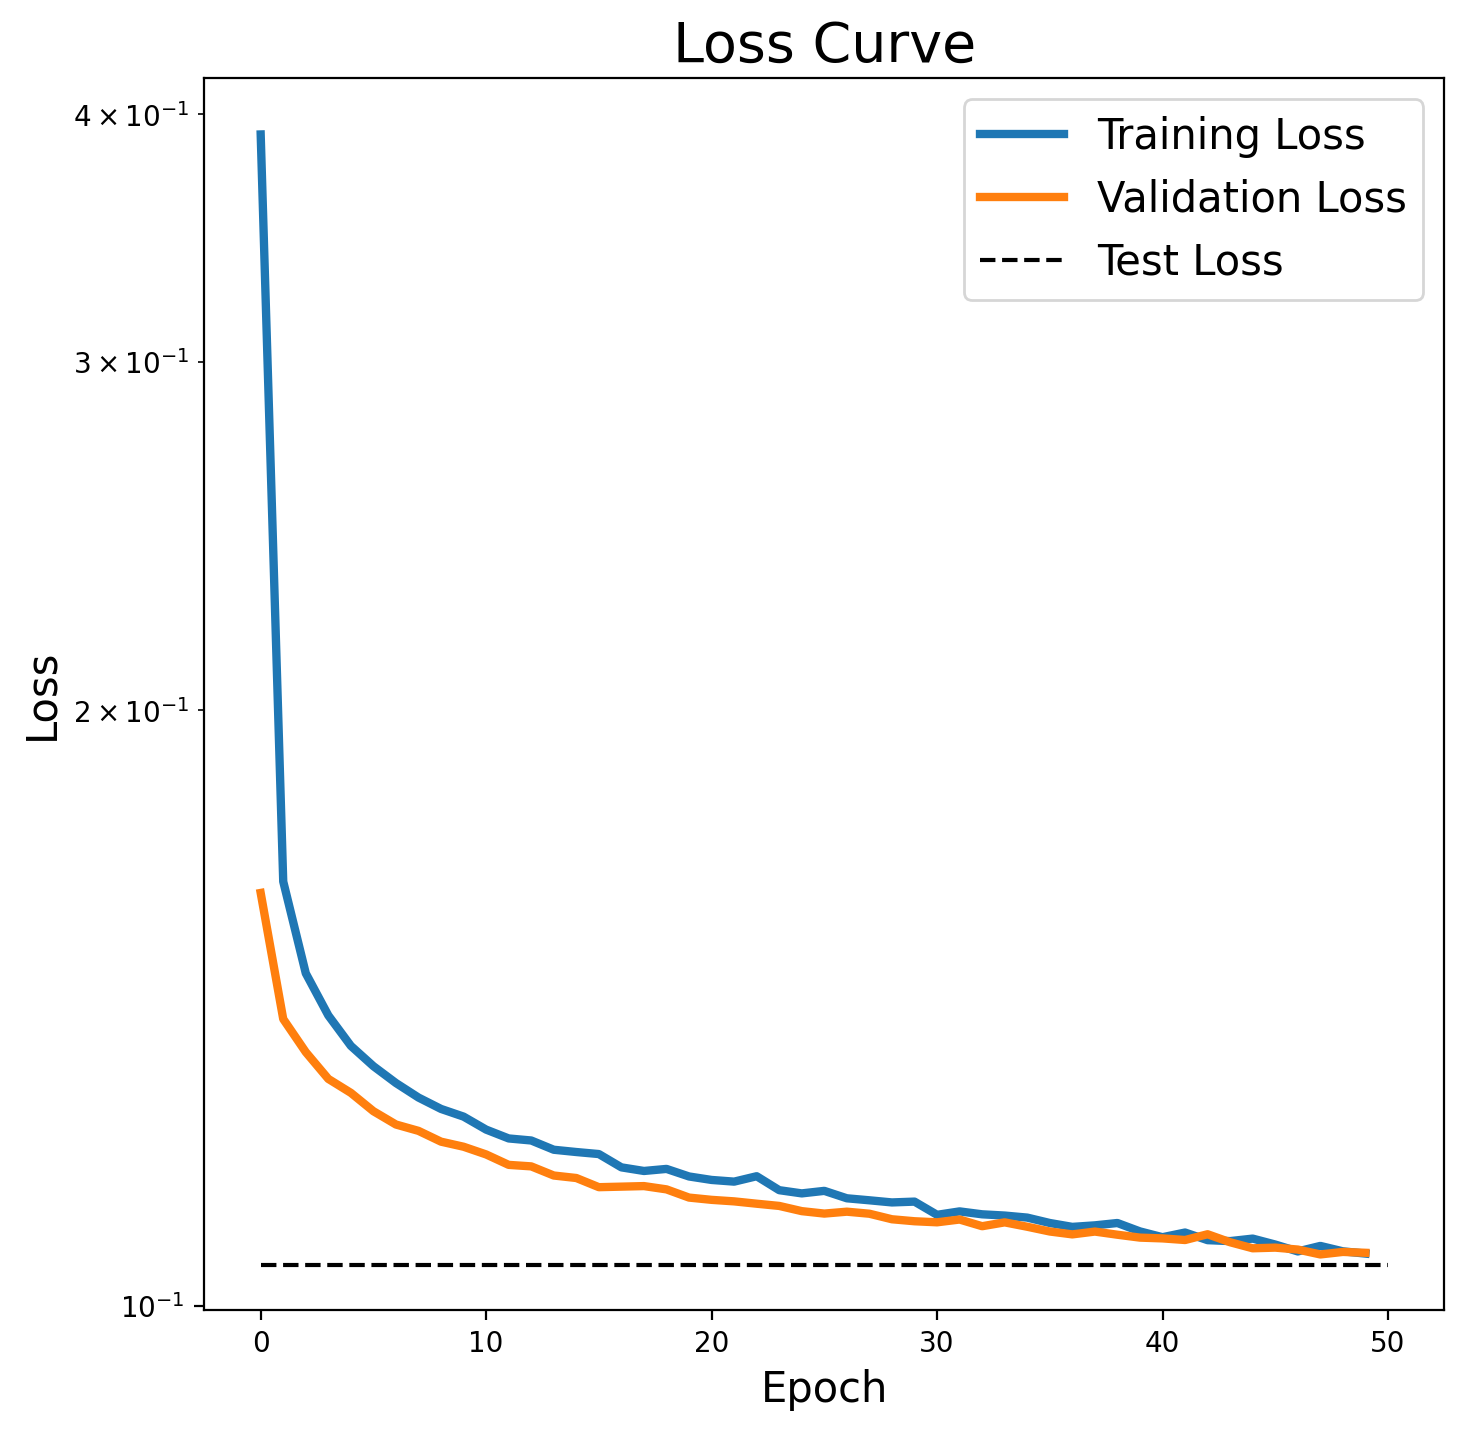

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 200)

ax.set_xlabel("Epoch", fontsize = 15)
ax.set_ylabel("Loss", fontsize = 15)
ax.set_title("Loss Curve", fontsize = 20)

ax.set_yscale('log')
ax.plot(range(50), trn_loss, linewidth = 3, label = 'Training Loss')
ax.plot(range(50), val_loss, linewidth = 3, label = 'Validation Loss')
ax.hlines(test_loss, 0, 50, linestyle = '--', color = 'k', label = 'Test Loss')

ax.legend(fontsize = 15)
plt.show()

In [15]:
print(metrics.multilabel_confusion_matrix(true, pred))

[[[477   0]
  [ 11   0]]

 [[477   0]
  [ 11   0]]

 [[471   0]
  [ 17   0]]

 [[484   0]
  [  4   0]]

 [[477   0]
  [ 11   0]]

 [[476   0]
  [ 12   0]]

 [[481   0]
  [  7   0]]

 [[459   0]
  [ 29   0]]

 [[476   0]
  [ 12   0]]

 [[479   0]
  [  9   0]]

 [[456   0]
  [ 32   0]]

 [[476   0]
  [ 12   0]]

 [[483   0]
  [  5   0]]

 [[487   0]
  [  1   0]]

 [[469   0]
  [ 19   0]]

 [[482   0]
  [  6   0]]

 [[483   0]
  [  5   0]]

 [[477   0]
  [ 11   0]]

 [[477   0]
  [ 11   0]]

 [[471   0]
  [ 17   0]]

 [[483   0]
  [  5   0]]

 [[472   0]
  [ 16   0]]

 [[465   0]
  [ 23   0]]

 [[481   0]
  [  7   0]]

 [[483   0]
  [  5   0]]

 [[485   0]
  [  3   0]]

 [[467   0]
  [ 21   0]]

 [[483   0]
  [  5   0]]

 [[483   0]
  [  5   0]]

 [[483   0]
  [  5   0]]

 [[449   0]
  [ 39   0]]

 [[479   0]
  [  9   0]]

 [[488   0]
  [  0   0]]

 [[478   0]
  [ 10   0]]

 [[477   0]
  [ 11   0]]

 [[482   0]
  [  6   0]]

 [[477   0]
  [ 11   0]]

 [[481   0]
  [  7   0]]

 [[481   0]
